In [77]:

import numpy as np, pandas as pd, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import re, os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)


device: cpu


In [78]:
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt"
assert os.path.exists(DATA_PATH), "경로가 올바른지 확인하세요."


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
def load_wisdm_raw(raw_path):
    rows = []
    with open(raw_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            # 콤마/공백 섞여 들어오는 경우가 있어 통합 정규화
            parts = re.split('[, ]+', line)
            if len(parts) < 6:
                continue
            user = parts[0]
            activity = parts[1]
            x = parts[-3]
            y = parts[-2]
            z = parts[-1].replace(';','')
            timestamp = ''.join(parts[2:-3])  # 남은 부분을 timestamp로 묶음
            try:
                rows.append([user, activity, int(timestamp), float(x), float(y), float(z)])
            except:
                # 형식 틀어진 라인은 스킵
                continue
    df = pd.DataFrame(rows, columns=['user','activity','timestamp','x','y','z'])
    df = df.sort_values(['user','activity','timestamp']).reset_index(drop=True)
    return df

df = load_wisdm_raw(DATA_PATH)
print(df.shape)
df


(1086465, 6)


,user,activity,timestamp,x,y,z
0,1,Downstairs,6552942304000,-0.15,9.15,-0.34
1,1,Downstairs,6552992292000,0.11,9.19,2.76
2,1,Downstairs,6553042310000,-4.06,7.40,4.02
3,1,Downstairs,6553092298000,-2.87,7.93,3.21
4,1,Downstairs,6553142347000,-0.19,10.04,4.82
...,...,...,...,...,...,...
1086460,9,Walking,9614392347000,12.37,7.70,3.49
1086461,9,Walking,9614442335000,10.84,6.78,1.14
1086462,9,Walking,9614492292000,8.01,5.05,-0.04
1086463,9,Walking,9614542341000,5.86,4.21,-1.18


In [80]:
df.isnull().sum()

,0
user,0
activity,0
timestamp,0
x,0
y,0
z,0


In [81]:
df['activity'].value_counts()

,count
activity,
Walking,418393
Jogging,336445
Upstairs,122869
Downstairs,100425
Sitting,59939
Standing,48394


In [82]:
print(df.shape)
print(df.head())


(1086465, 6)
  user    activity      timestamp     x      y     z
0    1  Downstairs  6552942304000 -0.15   9.15 -0.34
1    1  Downstairs  6552992292000  0.11   9.19  2.76
2    1  Downstairs  6553042310000 -4.06   7.40  4.02
3    1  Downstairs  6553092298000 -2.87   7.93  3.21
4    1  Downstairs  6553142347000 -0.19  10.04  4.82


In [83]:
# 1) 라벨 인코딩
le = LabelEncoder()
y_enc = le.fit_transform(y)
num_classes = len(le.classes_)
print("classes:", list(le.classes_), "=>", num_classes)

classes: [np.str_('Downstairs'), np.str_('Jogging'), np.str_('Sitting'), np.str_('Standing'), np.str_('Upstairs'), np.str_('Walking')] => 6


In [84]:
# 2) 데이터 섞기
idx = np.arange(len(X))
np.random.seed(42)
np.random.shuffle(idx)
X, y_enc = X[idx], y_enc[idx]


In [85]:
# 3) Train/Test Split
split = int(len(X)*0.8)
X_train, X_test = X[:split],  X[split:]
y_train, y_test = y_enc[:split], y_enc[split:]


## 표준화 과정
모델 입력인 x, y, z 값의 범위가 각각 다르기 때문에, 학습 안정화를 위해 평균을 0, 표준편차를 1로 맞추는 과정
즉, 입력 X값(센서 데이터)을 조정하는 과정

모델이 특정 축(x, y, z)의 값이 너무 크거나 작아 학습이 한쪽으로 치우치지 않도록 함.

In [86]:
# 4) StandardScaler 적용
scaler = StandardScaler()

# (윈도우 수, window_size, 3) → (윈도우 수 * window_size, 3) 로 reshape
shape = X_train.shape
X_train_flat = X_train.reshape(-1, shape[-1])
X_test_flat = X_test.reshape(-1, shape[-1])

# 학습 데이터만 fit
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

# 다시 원래 형태로 복원
X_train = X_train_scaled.reshape(shape)
X_test = X_test_scaled.reshape(X_test.shape)

print("X_train:", X_train.shape, "X_test:", X_test.shape)


X_train: (27062, 128, 3) X_test: (6766, 128, 3)


In [87]:
from scipy import stats
import numpy as np

# 하이퍼파라미터
WINDOW_SIZE = 128   # 한 윈도우 길이(시점 수)
STEP        = 32    # 이동 간격(작을수록 겹침 많음)

def make_windows_user_activity(df, window_size=WINDOW_SIZE, step=STEP):
    X_list, y_list = [], []

    # user와 activity별로 그룹핑
    for user, g in df.groupby(['user']):
        g = g.sort_values('timestamp')              # 시간순 정렬
        arr = g[['x', 'y', 'z']].values            # (N, 3)
        labels = g['activity'].values              # 각 시점의 라벨 배열
        n = len(arr)

        if n < window_size:                        # window_size보다 작으면 skip
            continue

        # 슬라이딩 윈도우 적용
        for start in range(0, n - window_size + 1, step):
            end = start + window_size
            seg = arr[start:end]                    # (window_size, 3)

            # 현재 윈도우 안의 activity 최빈값 계산(대표라벨)
            label_window = labels[start:end]
            most_common_label = stats.mode(label_window, keepdims=True)[0][0]

            X_list.append(seg)
            y_list.append(most_common_label)

    # 리스트를 numpy 배열로 변환
    X = np.stack(X_list, axis=0)                    # (num_windows, window_size, 3)
    y = np.array(y_list)                            # (num_windows,)
    return X, y


In [88]:
class WisdmDataset(Dataset):
    def __init__(self, X, y):
        # 1D-CNN 입력: (배치, 채널=3, 길이=window)
        self.X = torch.tensor(X, dtype=torch.float32).permute(0, 2, 1)  # (N,3,window)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_ds = WisdmDataset(X_train, y_train)
test_ds  = WisdmDataset(X_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False)
len(train_ds), len(test_ds)


(27062, 6766)

In [89]:
class SimpleCNN1D(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv1d(3, 32, kernel_size=5, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool1d(1)  # (B,128,1)
        )
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x)   # (B,128,1)
        x = x.squeeze(-1)      # (B,128)
        return self.fc(x)      # (B,C)

model = SimpleCNN1D(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [90]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    tot_loss, tot_correct, tot = 0.0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        tot_loss += loss.item() * xb.size(0)
        tot_correct += (logits.argmax(1) == yb).sum().item()
        tot += xb.size(0)
    return tot_loss / tot, tot_correct / tot

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    tot_loss, tot_correct, tot = 0.0, 0, 0
    all_pred, all_true = [], []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)
        tot_loss += loss.item() * xb.size(0)
        pred = logits.argmax(1)
        tot_correct += (pred == yb).sum().item()
        tot += xb.size(0)
        all_pred.append(pred.cpu().numpy())
        all_true.append(yb.cpu().numpy())
    return (tot_loss/tot), (tot_correct/tot), np.concatenate(all_pred), np.concatenate(all_true)

EPOCHS = 5
best_acc = 0.0

for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    te_loss, te_acc, te_pred, te_true = evaluate(model, test_loader, criterion)
    if te_acc > best_acc:
        best_acc = te_acc
        torch.save(model.state_dict(), "best_simple_cnn1d.pt")
    print(f"[{ep:02d}] train {tr_loss:.4f}/{tr_acc:.4f} | test {te_loss:.4f}/{te_acc:.4f}")

print("best test acc:", best_acc)


[01] train 1.5246/0.3693 | test 1.5214/0.3571
[02] train 1.4936/0.3817 | test 1.5183/0.3757
[03] train 1.4908/0.3863 | test 1.5260/0.3587
[04] train 1.4885/0.3857 | test 1.5283/0.3674
[05] train 1.4865/0.3877 | test 1.5211/0.3745
best test acc: 0.3757020396098138



[Classification Report]
              precision    recall  f1-score   support

  Downstairs       0.00      0.00      0.00       662
     Jogging       0.31      0.01      0.02      2089
     Sitting       0.00      0.00      0.00       395
    Standing       0.00      0.00      0.00       294
    Upstairs       0.00      0.00      0.00       786
     Walking       0.38      0.99      0.54      2540

    accuracy                           0.37      6766
   macro avg       0.11      0.17      0.09      6766
weighted avg       0.24      0.37      0.21      6766


Accuracy: 0.3745


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


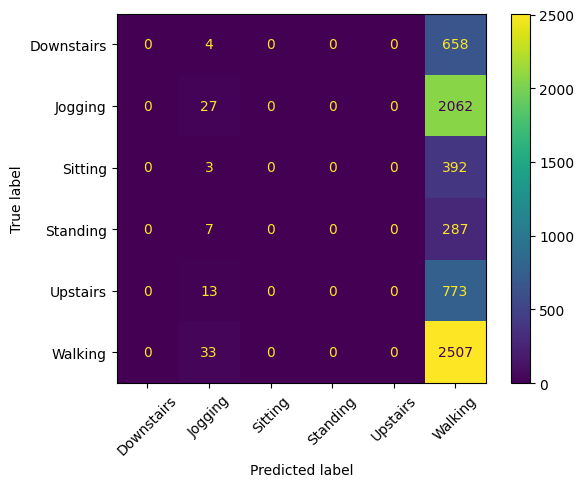


[Random predictions]
true=Jogging  pred=Walking
true=Walking  pred=Walking
true=Downstairs  pred=Walking
true=Standing  pred=Walking
true=Walking  pred=Walking
true=Jogging  pred=Walking
true=Walking  pred=Walking
true=Sitting  pred=Walking
true=Walking  pred=Walking
true=Walking  pred=Walking


In [91]:
print("\n[Classification Report]")
print(classification_report(te_true, te_pred, target_names=le.classes_))

from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(te_true, te_pred)
acc = accuracy_score(te_true, te_pred)
print(f"\nAccuracy: {acc:.4f}")
disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
disp.plot(xticks_rotation=45)
plt.show()

@torch.no_grad()
def show_random_predictions(model, dataset, n=10):
    model.eval()
    import numpy as np
    idxs = np.random.choice(len(dataset), size=min(n, len(dataset)), replace=False)
    for i in idxs:
        xb, yb = dataset[i]
        logits = model(xb.unsqueeze(0).to(device))
        pred = logits.argmax(1).item()
        print(f"true={le.classes_[yb.item()]}  pred={le.classes_[pred]}")

print("\n[Random predictions]")
show_random_predictions(model, test_ds, n=10)
